# UTILIZING EXTERNAL DATA FOR ENHANCING BUILDING ENERGY DEMAND ESTIMATION
## Part 2: Experiment
### Prepared by: Said Bolluk

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import timeit
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

# 1) Data Preprocessing

In [3]:
data = pd.read_csv("ready_data.csv")

In [4]:
data["CouncilDistrictCode"] = data["CouncilDistrictCode"].astype(str)
data["Climate Type"] = data["Climate Type"].astype(str)
data["Energy Efficiency Class"] = data["Energy Efficiency Class"].astype(str)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1821 non-null   object 
 1   Neighborhood               1821 non-null   object 
 2   CouncilDistrictCode        1821 non-null   object 
 3   Latitude                   1821 non-null   float64
 4   Longitude                  1821 non-null   float64
 5   YearBuilt                  1821 non-null   int64  
 6   NumberofFloors             1821 non-null   int64  
 7   PropertyGFABuilding(s)     1821 non-null   int64  
 8   Total Consumption (kbtu)   1821 non-null   float64
 9   Total EUI (kbtu/sf)        1821 non-null   float64
 10  Energy Use                 1821 non-null   object 
 11  Landmark                   1821 non-null   object 
 12  Wind Speed (kts)           1821 non-null   float64
 13  Daytime Temperature (C)    1821 non-null   float

In [6]:
# Define target
target = data["Total Consumption (kbtu)"]
main_data = data.drop(columns=["Total Consumption (kbtu)"])

Define feature combinations

In [7]:
normal_columns = [
    'BuildingType',
    'Neighborhood',
    'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
]

climate_columns = [
    'BuildingType',
    'Neighborhood',
    'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'Energy Use',
    'Landmark',
    'Wind Speed (kts)',
    'Daytime Temperature (C)',
    'Nighttime Temperature (C)',
    'Climate Type',
]

efficiency_columns = [
    'BuildingType',
    'Neighborhood',
    'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'Earthquake Risk',
    'Flood Risk',
    'Water Bodies',
    'Commercial',
    'Industrial',
    'Public Utilities',
    'Energy Efficiency Class',
]

mixed_columns = [
    'BuildingType',
    'Neighborhood',
    'CouncilDistrictCode',
    'Latitude',
    'Longitude',
    'YearBuilt',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'Energy Use',
    'Landmark',
    'Wind Speed (kts)',
    'Daytime Temperature (C)',
    'Nighttime Temperature (C)',
    'Climate Type',
    'Earthquake Risk',
    'Flood Risk',
    'Water Bodies',
    'Commercial',
    'Industrial',
    'Public Utilities',
    'Energy Efficiency Class',
]

Check the correlation between features and the target:

In [8]:
data.corr()["Total Consumption (kbtu)"]

Latitude                    -0.076924
Longitude                    0.029863
YearBuilt                    0.173866
NumberofFloors               0.707402
PropertyGFABuilding(s)       0.884253
Total Consumption (kbtu)     1.000000
Total EUI (kbtu/sf)          0.371233
Wind Speed (kts)             0.099616
Daytime Temperature (C)     -0.032184
Nighttime Temperature (C)    0.130781
Water Bodies                -0.042874
Commercial                  -0.098062
Industrial                  -0.038829
Public Utilities            -0.102065
Name: Total Consumption (kbtu), dtype: float64

Define the datasets with different feature combinations

In [9]:
normal_data = main_data.loc[:, normal_columns]
climate_data = main_data.loc[:, climate_columns]
efficiency_data = main_data.loc[:, efficiency_columns]
mixed_data = main_data.loc[:, mixed_columns]

Define a function that performs data preprocessing

In [10]:
def dataset_prep(data, data_id):
    
    # Encoding categorical variables
    mydf = pd.get_dummies(data)
    
    X = mydf
    y = target.values
    
    test_ratio = 0.20
    
    if data_id == 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, 
            stratify=data["Neighborhood"],
            shuffle=True, random_state=42,
        )
        
    elif data_id == 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, 
            stratify=data["Climate Type"],
            shuffle=True, random_state=42,
        )
        
    elif (data_id == 2) | (data_id == 3):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_ratio, 
            stratify=data["Energy Efficiency Class"],
            shuffle=True, random_state=42,
        )
    
    # Scaling numerical variables
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# 2) Training

Collect the results for different feature combinations for regression models in the **report_df**

In [11]:
report_df = pd.DataFrame()

Set the random seed for reproducibility:

In [12]:
np.random.seed(42)
random.seed(42)

## 2.1) Linear Regresssion

In [13]:
model = LinearRegression()

In [14]:
possible_combinations = [
    "normal_data",
    "climate_data",
    "efficiency_data",
    "mixed_data",
]

data_id = 0

for a in possible_combinations:
    
    # Determine the dataset
    if a == "normal_data":
        mydf = normal_data
        data_id = 0
        
    elif a == "climate_data":
        mydf = climate_data
        data_id = 1
        
    elif a == "efficiency_data":
        mydf = efficiency_data
        data_id = 2
        
    elif a == "mixed_data":
        mydf = mixed_data
        data_id = 3
        
    X_train_scaled, X_test_scaled, y_train, y_test = dataset_prep(mydf, data_id)
    
    # Set the random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Model Training    
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    # Result Evaluation: MSE and R2
    total_error = list()

    for i in range(y_test.shape[0]):
        error = abs((y_test[i]-predictions[i]) / y_test[i])
        total_error.append(error)

    mean_error = np.mean(total_error)
    std_error = np.std(total_error)
    r2 = r2_score(y_test, predictions)
    
    # Save the results
    result_dict = {
        "Model": "Linear Regression",
        "Dataset": a,
        "Mean Absolute Percentage Error": np.round(mean_error, 3),
        "Std. of Error": np.round(std_error, 3),
        "R2 Score": np.round(r2, 3),
    }
    
    report_df = report_df.append(result_dict, ignore_index=True, sort=True)

In [15]:
# Print the results
report_df[["Model", "Dataset", "R2 Score", "Mean Absolute Percentage Error", "Std. of Error"]]

,Model,Dataset,R2 Score,Mean Absolute Percentage Error,Std. of Error
0,Linear Regression,normal_data,0.831,0.348,0.331
1,Linear Regression,climate_data,0.704,0.624,0.646
2,Linear Regression,efficiency_data,0.827,0.386,0.575
3,Linear Regression,mixed_data,0.514,1.043,1.016


# 2.2) Trial with MLP Regressor

Perform a hyperparameter tuning to get the best out of the MLP Regressor. In this context, the **normal dataset** with the original features will be used.

In [16]:
#MLP Regressor with the optimal hyperparameters:
model = MLPRegressor(
    activation="identity",
    learning_rate_init=0.05,
    max_iter=500,
    momentum=0.5,
    random_state=42,
)

possible_combinations = [
    "normal_data",
    "climate_data",
    "efficiency_data",
    "mixed_data",
]

data_id = 0

for a in possible_combinations:
    
    # Determine the dataset
    if a == "normal_data":
        mydf = normal_data
        data_id = 0
        
    elif a == "climate_data":
        mydf = climate_data
        data_id = 1
        
    elif a == "efficiency_data":
        mydf = efficiency_data
        data_id = 2
        
    elif a == "mixed_data":
        mydf = mixed_data
        data_id = 3
        
    X_train_scaled, X_test_scaled, y_train, y_test = dataset_prep(mydf, data_id)
    
    # Set the random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Model Training    
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    # Result Evaluation: MSE and R2
    total_error = list()

    for i in range(y_test.shape[0]):
        error = abs((y_test[i]-predictions[i]) / y_test[i])
        total_error.append(error)

    mean_error = np.mean(total_error)
    std_error = np.std(total_error)
    r2 = r2_score(y_test, predictions)
    
    # Save the results
    result_dict = {
        "Model": "MLP Regressor",
        "Dataset": a,
        "Mean Absolute Percentage Error": np.round(mean_error, 3),
        "Std. of Error": np.round(std_error, 3),
        "R2 Score": np.round(r2, 3),
    }
    
    report_df = report_df.append(result_dict, ignore_index=True, sort=True)

C:\Users\User\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\User\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\User\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\User\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  Converge

## 2.3) Random Forest Regressor

We will observe the relationship between R2 and MAPE as we analyze different tree depth utilized in te random trees of the RandomForestRegressor. This will provide us a more generalized overview on different datasets.

In [17]:
# Normal Data
X = pd.get_dummies(normal_data)
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

r2_training = list()
r2_test = list()
mape_training = list()
mape_test = list()

max_depth_options = np.arange(2, 22, 2)

for depth in max_depth_options:

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        criterion="absolute_error",
        random_state=42,
    )

    # Fit the model and make predictions
    model.fit(X_train_scaled, y_train)
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)

    # Result evaluation
    r2_training.append(r2_score(y_train, pred_train))
    r2_test.append(r2_score(y_test, pred_test))
    mape_training.append(mean_absolute_percentage_error(y_train, pred_train))
    mape_test.append(mean_absolute_percentage_error(y_test, pred_test))

Result Visualization

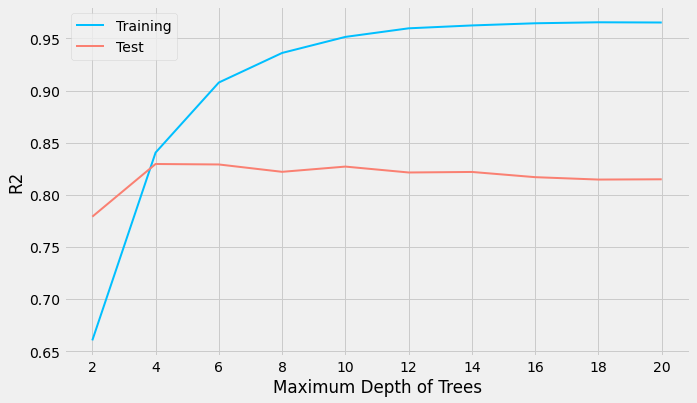

In [18]:
# 1) Validation Curve: R2
plt.figure(figsize=(10, 6))
plt.plot(max_depth_options, r2_training, color="deepskyblue", lw=2, label="Training")
plt.plot(max_depth_options, r2_test, lw=2, color="salmon", label="Test")
plt.legend()
plt.xlabel("Maximum Depth of Trees")
plt.ylabel("R2")
#plt.title("Validation Curve: R2")
plt.xticks(np.arange(2, 22, 2))
plt.show()

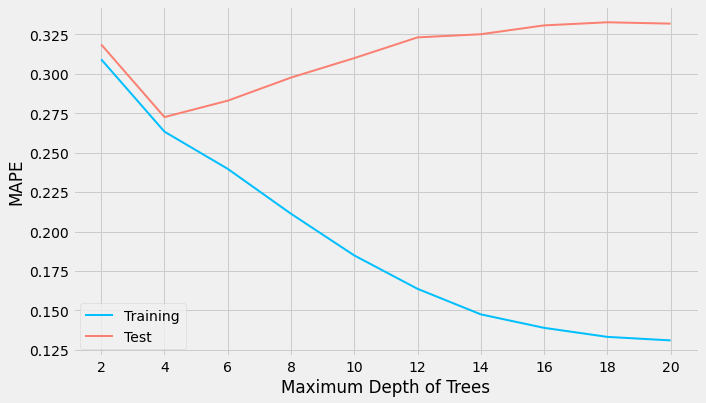

In [19]:
# 2) Validation Curve: MAPE
plt.figure(figsize=(10, 6))
plt.plot(max_depth_options, mape_training, color="deepskyblue", lw=2, label="Training")
plt.plot(max_depth_options, mape_test, color="salmon", lw=2, label="Test")
plt.legend()
plt.xlabel("Maximum Depth of Trees")
plt.ylabel("MAPE")
#plt.title("Validation Curve: MAPE")
plt.xticks(np.arange(2, 22, 2))
plt.show()

We can see from the graph below that as we increase the tree depth, the model fits better the training data but looses it prediction power on the test data. Let us visualize this estimation process of the Random Forest Regressor with different tree depths. We select a sample feature column called **PropertyGFABuilding(s)** beacuse it has a high correlation with the target, which makes easier to visualize non-parametric regression of the Random Forest estimator.

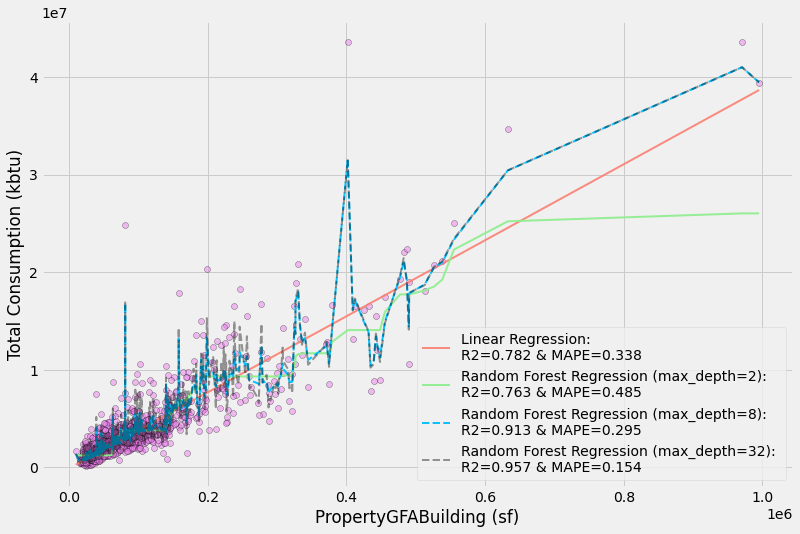

In [20]:
X = np.reshape(data["PropertyGFABuilding(s)"].values, (-1, 1))
y = data["Total Consumption (kbtu)"].values

# Define models
x_ticks = np.reshape(np.sort(data["PropertyGFABuilding(s)"].values), (-1, 1))

linear = LinearRegression()
linear.fit(X, y)

forest1 = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42)
forest1.fit(X, y)

forest2 = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
forest2.fit(X, y)

forest3 = RandomForestRegressor(n_estimators=100, max_depth=32, random_state=42)
forest3.fit(X, y)

# Make prediction
lin_preds = linear.predict(x_ticks)
forest1_preds = forest1.predict(x_ticks)
forest2_preds = forest2.predict(x_ticks)
forest3_preds = forest3.predict(x_ticks)

# Model Evaluation
r2_linear = r2_score(y, linear.predict(X))
mape_linear = mean_absolute_percentage_error(y, linear.predict(X))

r2_forest1 = r2_score(y, forest1.predict(X))
mape_forest1 = mean_absolute_percentage_error(y, forest1.predict(X))

r2_forest2 = r2_score(y, forest2.predict(X))
mape_forest2 = mean_absolute_percentage_error(y, forest2.predict(X))

r2_forest3 = r2_score(y, forest3.predict(X))
mape_forest3 = mean_absolute_percentage_error(y, forest3.predict(X))

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X, y, edgecolor="black", c="violet", alpha=0.5)


plt.plot(
    x_ticks, 
    lin_preds, 
    label=f"Linear Regression: \nR2={r2_linear:.3f} & MAPE={mape_linear:.3f}",
    alpha=0.9,
    color="salmon",
    lw=2,
    linestyle='solid',
)

plt.plot(
    x_ticks, 
    forest1_preds, 
    label=f"Random Forest Regression (max_depth={2}): \nR2={r2_forest1:.3f} & MAPE={mape_forest1:.3f}",
    color="lightgreen",
    alpha=0.95,
    lw=2,
)

plt.plot(
    x_ticks, 
    forest2_preds, 
    label=f"Random Forest Regression (max_depth={8}): \nR2={r2_forest2:.3f} & MAPE={mape_forest2:.3f}",
    color="deepskyblue",
    alpha=0.95,
    lw=2,
    linestyle='dashed',
)

plt.plot(
    x_ticks, 
    forest3_preds, 
    label=f"Random Forest Regression (max_depth={32}): \nR2={r2_forest3:.3f} & MAPE={mape_forest3:.3f}",
    lw=2,
    color="black",
    alpha=0.4,
    linestyle='dashed',
)

plt.legend()
plt.xlabel("PropertyGFABuilding (sf)")
plt.ylabel("Total Consumption (kbtu)")
plt.show()

According to the **Validation Curve**, the optimal number of estimators is X. We will use this number to train all our models for the consistency of the results comparison.

In [21]:
optimal_depth = 4

Define a RandomForestRegressor using the optimal number of estimators for the normal_data.

In [22]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=optimal_depth,
    criterion="absolute_error",
    random_state=42,
)

In [23]:
possible_combinations = [
    "normal_data",
    "energy_use_data",
    "climate_data",
    "efficiency_data",
    "mixed_data",
]

data_id = 0

for a in possible_combinations:
    
    # Determine the dataset
    if a == "normal_data":
        mydf = normal_data
        data_id = 0
        
    elif a == "climate_data":
        mydf = climate_data
        data_id = 1
        
    elif a == "efficiency_data":
        mydf = efficiency_data
        data_id = 2
        
    elif a == "mixed_data":
        mydf = mixed_data
        data_id = 3
        
    X_train_scaled, X_test_scaled, y_train, y_test = dataset_prep(mydf, data_id)
    
    # Set the random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Model Training    
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    # Result Evaluation: MSE and R2
    total_error = list()

    for i in range(y_test.shape[0]):
        error = abs((y_test[i]-predictions[i]) / y_test[i])
        total_error.append(error)

    mean_error = np.mean(total_error)
    std_error = np.std(total_error)
    r2 = r2_score(y_test, predictions)
    
    # Save the results
    result_dict = {
        "Model": "Random Forest Regressor",
        "Dataset": a,
        "Mean Absolute Percentage Error": np.round(mean_error, 3),
        "Std. of Error": np.round(std_error, 3),
        "R2 Score": np.round(r2, 3),
    }
    
    report_df = report_df.append(result_dict, ignore_index=True, sort=True)

In [24]:
# Print the results
report_df = report_df[["Model", "Dataset", "R2 Score", "Mean Absolute Percentage Error", "Std. of Error"]]

Sort the results as the model with less error is on the top:

In [25]:
report_df.sort_values(by=["Mean Absolute Percentage Error"], ascending=True)

,Model,Dataset,R2 Score,Mean Absolute Percentage Error,Std. of Error
10,Random Forest Regressor,climate_data,0.646,0.249,0.294
8,Random Forest Regressor,normal_data,0.796,0.262,0.242
9,Random Forest Regressor,energy_use_data,0.796,0.262,0.242
12,Random Forest Regressor,mixed_data,0.813,0.283,0.449
11,Random Forest Regressor,efficiency_data,0.816,0.298,0.434
5,MLP Regressor,climate_data,0.693,0.315,0.326
0,Linear Regression,normal_data,0.831,0.348,0.331
6,MLP Regressor,efficiency_data,0.821,0.364,0.493
7,MLP Regressor,mixed_data,0.828,0.365,0.463
4,MLP Regressor,normal_data,0.802,0.367,0.376


Save the results to a csv file:

In [26]:
report_df.to_csv("results.csv")

# Feature Importance

Mean Decrease in Impurity: Let us analyze the most important features that determined the regression results on the **mixed_data.**

In [27]:
X_train_scaled, X_test_scaled, y_train, y_test = dataset_prep(mixed_data, 3)
    
# Set the random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define a model

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    criterion="absolute_error",
    random_state=42,
)

# Model Training    
model.fit(X_train_scaled, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=4, random_state=42)

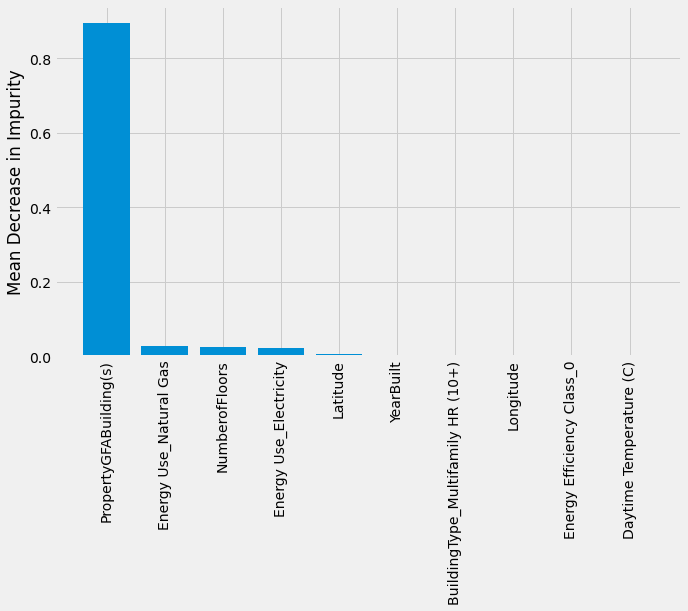

In [28]:
# Mean Decrease in Impurity
data = pd.get_dummies(mixed_data)

feature_index = [i for i in range(data.shape[1])]
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_index)
top_ten_index = forest_importances.sort_values(ascending=False)[:10].index.tolist()
top_ten_importances = forest_importances.sort_values(ascending=False)[:10].values.tolist()

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)


top_ten_feature_names = [data.columns.tolist()[i] for i in top_ten_index]


#Visualization
forest_importances_top_ten = pd.Series(top_ten_importances, index=top_ten_feature_names)
plt.figure(figsize=(10, 6))
#forest_importances.plot.bar(yerr=std, ax=ax)
plt.bar(x=forest_importances_top_ten.index, height=forest_importances_top_ten.values)
plt.xticks(rotation="vertical")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

In [29]:
five_important = forest_importances.sort_values(ascending=False)[:10]
initial_ind = 0
count = 1
for i in five_important.index:
    print(f"{count}. {data.columns.tolist()[i]} with MDI: {five_important.values[initial_ind]:.3f}")
    initial_ind += 1
    count += 1

1. PropertyGFABuilding(s) with MDI: 0.895
2. Energy Use_Natural Gas with MDI: 0.028
3. NumberofFloors with MDI: 0.026
4. Energy Use_Electricity with MDI: 0.021
5. Latitude with MDI: 0.005
6. YearBuilt with MDI: 0.004
7. BuildingType_Multifamily HR (10+) with MDI: 0.004
8. Longitude with MDI: 0.004
9. Energy Efficiency Class_0 with MDI: 0.002
10. Daytime Temperature (C) with MDI: 0.001


Save the top ten determinant features to a csv file:

In [30]:
forest_importances_top_ten = pd.Series(top_ten_importances, index=top_ten_feature_names)
forest_importances_top_ten.to_csv("top_ten.csv")

# END